In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from  statsmodels.tsa.stattools import adfuller,kpss 
import statsmodels.api
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_log_error 
from sklearn.model_selection import GridSearchCV
#from pyti.relative_strength_index import relative_strength_index as rsi
from sklearn import preprocessing
import seaborn as sns

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def accuracy_metrics(y_true,y_pred): 
    mse=mean_squared_error(y_true,y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    msle=mean_squared_log_error(y_true,y_pred)
    return [mse,mae,msle]

def standartize(x):
    
    min_max_scaler = preprocessing.MinMaxScaler()
    data_scaled=pd.DataFrame(min_max_scaler.fit_transform(np.array(x.drop(columns=['time']))))
    data_scaled.columns=[n for n in x.columns if n!='time']
    return data_scaled

#technical indicators:
def ema(x,s):
    
    return np.array(x.ewm(span=s).mean())


def bollinger(x,w):
   
    rolling_mean = x.rolling(w).mean()
    rolling_std = x.rolling(w).std()
    roll_mean = rolling_mean
    higher_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return [lower_band[w:],roll_mean[w:],higher_band[w:]]


def macd(v): 
    
    return ema(v,12)-ema(v,26)

def momentum(x,y):
    return (x/x.shift(y))*100

def a_d(cllose,low,high,vol):
  
    return ((close-low)-(high-close)*vol)/(high-low)

def calculate_indicators(dat,z,x,c,v,d):
    
    dat['ema']=ema(dat['mid'],z)
    dat['b_low']=bollinger(dat['mid'],x)[0]
    dat['ma']=bollinger(dat['mid'],c)[1]
    dat['b_high']=bollinger(dat['mid'],v)[2]
    #dat['rsi']=rsi(np.array(dat['mid']),0)
    dat['macd']=macd(dat['mid'])
    dat['momentum']=momentum(dat['mid'],d)
    dat = dat.iloc[max(z,x,c,v,d):,:]
    return dat

def clean_data(data):
    data['Local time']=[data['Local time'][i].replace(' GMT+0300','')for i in range(len(data['Local time']))]
    data['time']=[data['Local time'][i].replace('.','/',2)for i in range(len(data['Local time']))]
    data['time']=[datetime.strptime(data['time'][i], '%d/%m/%Y %H:%M:%S.%f') for i in range(len(data['Local time']))]
    data=data.drop(columns='Local time')
    data.columns=[x.lower() for x in list(data.columns)]
    data['mid']=(data['ask']+data['bid'])/2
    data['totalvolume']=data['askvolume']+data['bidvolume']
    data['perc_ch']=data['mid'].diff(periods=1)
    data=data.iloc[1:,:]
    return data


In [3]:
#read data
data=pd.read_csv('AMZN.csv')
#format data
data=clean_data(data)
data=calculate_indicators(data,20,20,20,20,30)

C:\Users\Dell\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


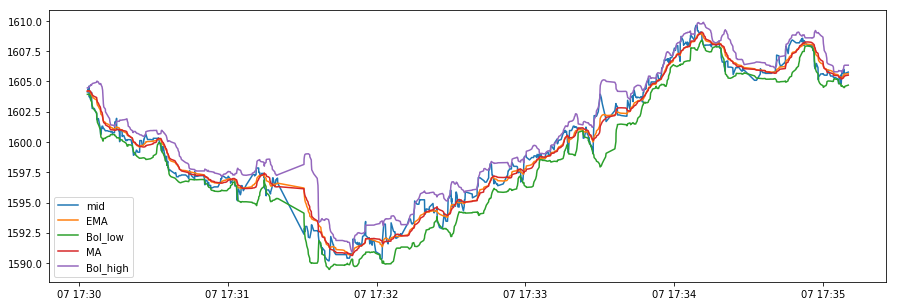

In [4]:
plt.figure(figsize=(15,5))
plt.plot(data['time'][:1000],data['mid'][:1000])
plt.plot(data['time'][:1000],data['ema'][:1000],label='EMA')
plt.plot(data['time'][:1000],data['b_low'][:1000],label='Bol_low')
plt.plot(data['time'][:1000],data['ma'][:1000],label='MA')
plt.plot(data['time'][:1000],data['b_high'][:1000],label='Bol_high')
plt.legend()
plt.show()
#trend is obviuos, indicating varyinfg mean->non-stationary.Still, perform ADF and KPSS tests on stationarity

In [5]:
#calculate one-minute summary
def one_minute(x,y):
    x=pd.concat([x,grouped[[y]].max()],axis=1)
    x=pd.concat([x,grouped[[y]].min()],axis=1)
    x=pd.concat([x,grouped[[y]].nth(0)],axis=1)
    x=pd.concat([x,grouped[[y]].nth(-1)],axis=1)
    return x

bytime = pd.DatetimeIndex(data['time'])
grouped = data.groupby(bytime.minute)
mindata=grouped[['ask']].max()
mindata=pd.concat([mindata,grouped[['ask']].min()],axis=1)
mindata=pd.concat([mindata,grouped[['ask']].nth(0)],axis=1)
mindata=pd.concat([mindata,grouped[['ask']].nth(-1)],axis=1)
mindata=one_minute(mindata,'bid')
mindata=one_minute(mindata,'mid')
mindata.columns=['ask_high','ask_low','ask_open','ask_close','bid_high','bid_low','bid_open','bid_close','mid_high','mid_low','mid_open','mid_close']
mindata.head(3)

,ask_high,ask_low,ask_open,ask_close,bid_high,bid_low,bid_open,bid_close,mid_high,mid_low,mid_open,mid_close
time,,,,,,,,,,,,
0,1627.313,1603.112,1606.572,1621.192,1626.157,1602.277,1604.467,1619.898,1626.7315,1602.7270,1605.5195,1620.5450
1,1627.013,1601.163,1606.572,1622.012,1625.741,1599.797,1604.569,1621.201,1626.3470,1600.8045,1605.5705,1621.6065
2,1626.693,1600.122,1602.902,1623.713,1625.618,1599.098,1602.177,1622.841,1626.1450,1599.6620,1602.5395,1623.2770


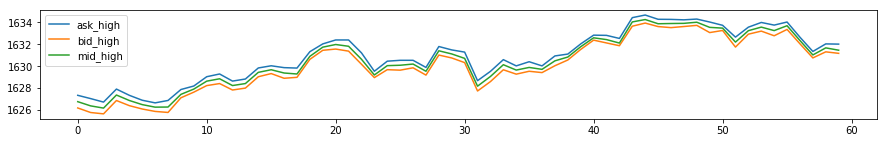

In [6]:
plt.figure(figsize=(15,2))
plt.plot(mindata['ask_high'])
plt.plot(mindata['bid_high'])
plt.plot(mindata['mid_high'])
plt.legend()

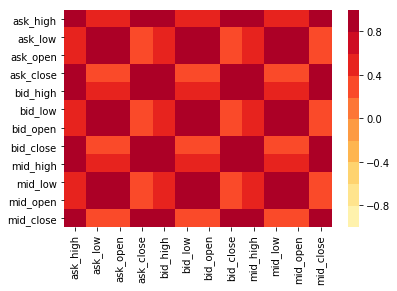

In [7]:
cor0=mindata.corr()
sns.heatmap(cor0,vmin=-1,vmax=1,center=0,cmap=sns.color_palette("YlOrRd",10))

In [8]:
#test for autocorrelation (Ljung-Box test of autocorrelation in residuals)
statsmodels.stats.diagnostic.acorr_ljungbox(data['mid'])[1]#p-values
#there is autocorrelation present

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

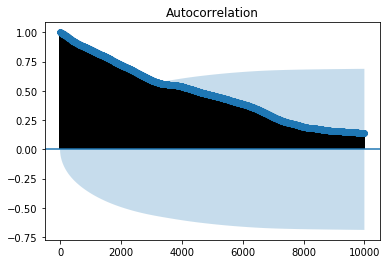

<Figure size 3.6x3.6 with 0 Axes>

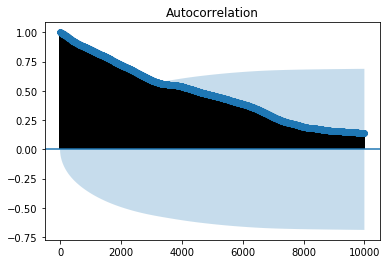

In [9]:
plt.figure(figsize=(0.05,0.05))
plot_acf(data['mid'],lags=10000)#no decrease in autocorrelation even after 10000 lags
#slow decrease, does not converge to zero, a sign of non-stationarity

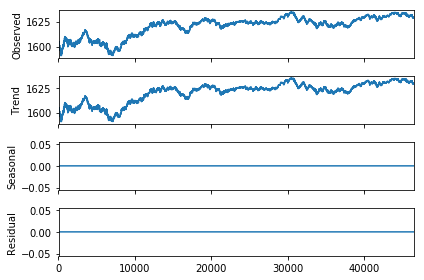

<Figure size 72x72 with 0 Axes>

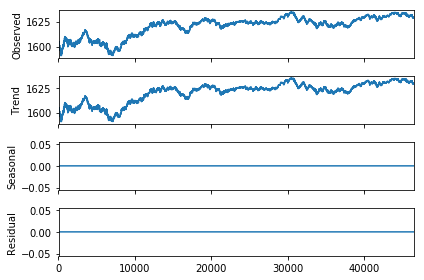

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose=seasonal_decompose(data[['ask']],freq=1)
plt.figure(figsize=(1,1))
decompose.plot() #no seasonality or patterns

In [11]:
#midprice=np.array(dat['Mid'])
adfuller(data['mid'],maxlag=7)[1]
#p-value is 40%, so we detect non-stationarity

0.386967318483316

In [12]:
#KPSS test
kpss(data['mid'])[1]
#p-value<1%, with 56 lags. So, this test tells that there is  nonstationarity (Ho:staionary)

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


0.01

In [13]:
delt=data['mid']
delt=delt.diff(periods=1)
delt.iloc[0]=0
delt=np.array(delt)
adfuller(delt,maxlag=7)[1] #differencing removes non-stationarity, so work with new data

0.0

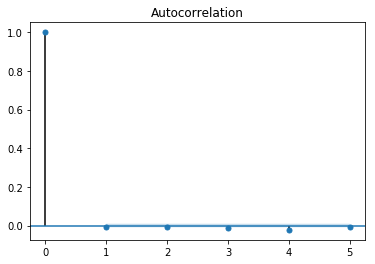

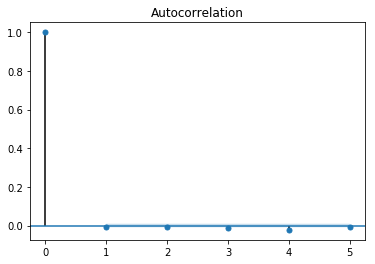

In [14]:
plot_acf(delt,lags=5)#no autocorrelation between lags

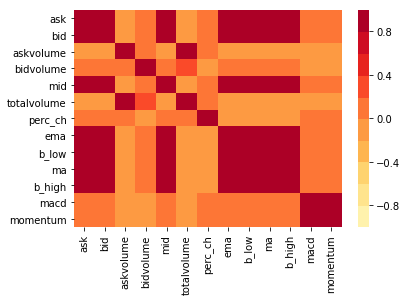

In [15]:

cor=data.corr()
sns.heatmap(cor,vmin=-1,vmax=1,center=0,cmap=sns.color_palette("YlOrRd",10))

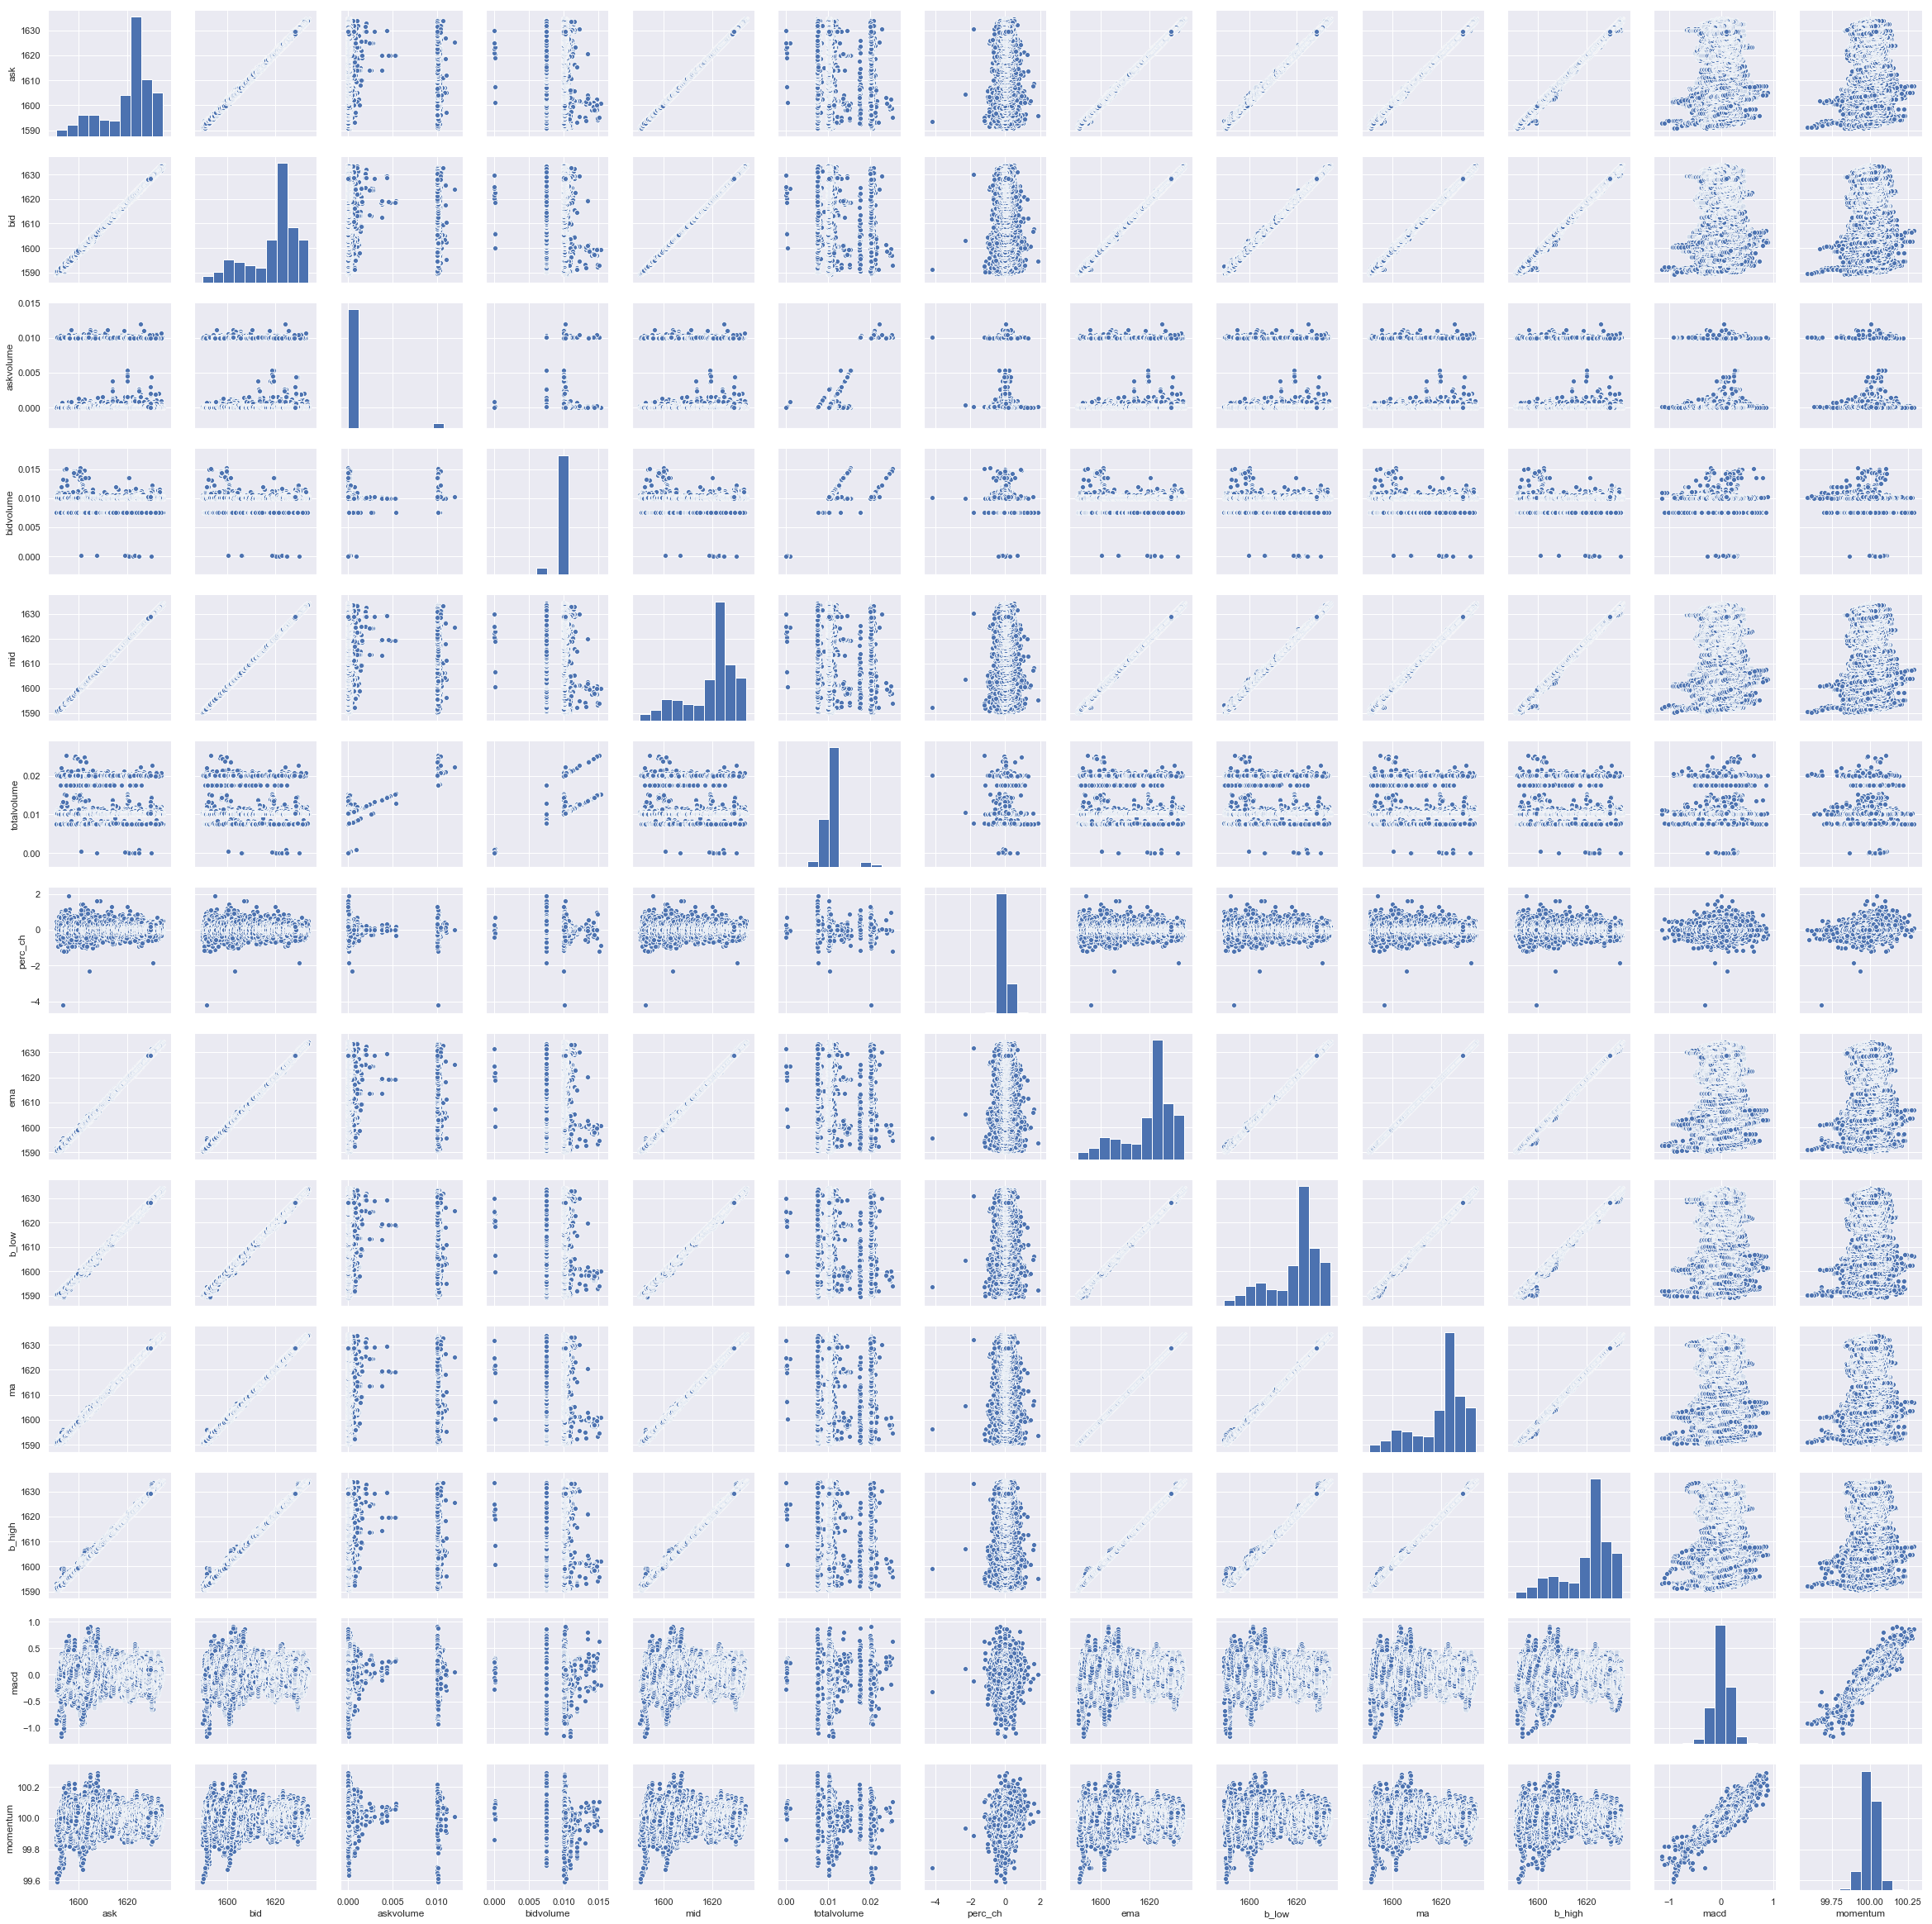

In [16]:
sns.set(color_codes=True)
n=list(data.columns)
n.remove('time')
sns.pairplot(data,vars=n,palette="YlOrRd")
plt.show()

In [4]:
def prepare_sample(data):
    data_splt=data[['mid','ema','b_low']]
    data_splt.columns=['mid','ema','b_low']
    X1=data_splt.loc[:,['ema','b_low']]
    #X1['ask']=X1.loc[:,'ask'].shift(10)
    #X1['bid']=X1.loc[:,'bid'].shift(10)
    #X1['mid']=X1.loc[:,'mid'].shift(10)
    #X1=X1.iloc[10:,:]
    X1=np.array(X1).reshape(X1.shape[0],X1.shape[1])
    Y1=data_splt[['mid']]
    #Y1=Y1.iloc[10:]
    Y1=np.array(Y1).ravel()
    return [X1,Y1]

In [5]:
sample=prepare_sample(data)
X1,Y1=sample[0],sample[1]

In [7]:
#Feature selection via Random Forest(current data)
from sklearn.ensemble import RandomForestRegressor
regrRF = RandomForestRegressor(max_depth=2,n_estimators=100)
regrRF.fit(X1,Y1)
regrRF.feature_importances_

array([1., 0.])

In [21]:
#Feature selection via Random Forest(other data) - the same results - ema only is significant
def feature_RF(file_n):
    data_feat=pd.read_csv(file_n + '.csv')
    data_feat=clean_data(data_feat)
    data_feat=calculate_indicators(data_feat,15,15,15,15,30)
    data_feat=prepare_sample(data_feat)
    regrRF = RandomForestRegressor(max_depth=2,n_estimators=200)
    regrRF.fit(X1,Y1)
    return print(regrRF.feature_importances_)

feature_RF('AMZNfeat')#2019 December
feature_RF('AMZNfeat2')#2019 June

[0.99160632 0.00839368]
[0.99580845 0.00419155]


In [ ]:
#scopt
from skopt import gbrt_minimize
from skopt.space import Real, Integer,Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
space = [Real(0, 50, name='C'),
         Real(0, 8, name='epsilon'),
         Categorical(name="kernel", categories=["linear","poly"])
        ]
model=SVR(gamma='scale')

@use_named_args(space)
def objective(**params):
    model.set_params(**params)

    return np.mean(cross_val_score(model, X1, Y1, cv=TimeSeriesSplit(n_splits = 3), n_jobs=-1,
                                    scoring='neg_mean_squared_error'))         
res =  gbrt_minimize(objective, space, n_calls=50)
res

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective(trial):
    c = trial.suggest_int('C',1,2000)
    k=trial.suggest_categorical('kernel',['linear','poly'])
    ep=trial.suggest_uniform('epsilon',0,7)
    sv = SVR(kernel=k,C=c,epsilon=ep,gamma='scale')
    return np.mean(cross_val_score(sv, X1, Y1, cv=TimeSeriesSplit(n_splits = 3), n_jobs=-1,scoring='neg_mean_squared_error'))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
#hyperopt
from hyperopt import hp
space={'C': hp.choice('C',range( 0, 1000,1)),
    'kernel': hp.choice('kernel', [
        {'ktype': 'linear'},
        {'ktype': 'poly'}]),'epsilon':hp.uniform('epsilon',range(0,7))}


trials = Trials()
_ = fmin(objective, SPACE, trials=trials, algo=tpe.suggest, **HPO_PARAMS)




In [ ]:
#SVR
X1,Y1=prepare_sample(data)
tss = TimeSeriesSplit(n_splits = 2)
MSE=list()
MAE=list()
MSLE=list()
for train_index, test_index in tss.split(X1):
    
    xtrainmid, xtestmid = X1[train_index], X1[test_index]
    ytrainmid, ytestmid = Y1[train_index], Y1[test_index]
    xtrainmid=np.array(xtrainmid)
    xtrainmid=xtrainmid.reshape(xtrainmid.shape[0],xtrainmid.shape[1])
    ytrainmid=np.array(ytrainmid).reshape(ytrainmid.shape[0],)
    xtestmid=np.array(xtestmid).reshape(xtestmid.shape[0],xtestmid.shape[1])
    ytestmid=np.array(ytestmid).reshape(ytestmid.shape[0],)
    
    Svr=SVR(kernel='linear',C=10.0, epsilon=2,gamma='scale')
    Svr.fit(xtrainmid, ytrainmid)
    metrics=accuracy_metrics(ytestmid,Svr.predict(xtestmid)) 
    MSE.append(metrics[0])
    MAE.append(metrics[1])
    MSLE.append(metrics[2])
    
MSE=np.array(MSE).mean()
MAE=np.array(MAE).mean()
MSLE=np.array(MSLE).mean()
print('MSE is {}, MAE is {},MSLE is {}'.format(MSE,MAE,MSLE))

In [9]:
#rolling window predictions
files=['AMZN_1','AMZN_2']
test_mse=list()
total_predictions=list()
total_true_val=list()
#read files,append names
i=0
while i <len(files):
    f=files[i]
    f=pd.read_csv(f+'.csv')
    f=clean_data(f)
    test_data=calculate_indicators(f,20,20,20,20,30)
    test_data=prepare_sample(test_data)
    pred=Svr.predict(test_data[0])
    test_mse.append(mean_squared_error(test_data[1],pred))
    total_predictions.extend(list(pred))
    total_true_val.extend(list(test_data[1]))
    Svr.fit(test_data[0],pred)
    i+=1
    
print(np.array(test_mse).mean())

4.459103705319706


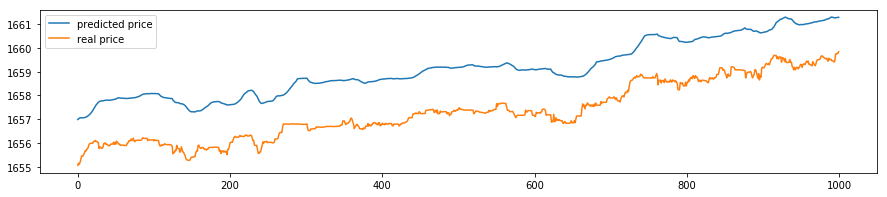

In [24]:
plt.figure(figsize=(15,3))
plt.plot(total_predictions[-1000:], label='predicted price')
plt.plot(total_true_val[-1000:],label='real price')
plt.legend()

In [ ]:
cv.best_score_ #-1.0359704118784966e-07
cv.best_estimator_ #SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='scale',
  #kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)